In [1]:
# Importing the Modules
from scripts.py_functions  import list_datasets, plot_selection

In [2]:
# Listing the existing datasets in the output folder
datasets_input = list_datasets()

2 datasets found in output\r_datar_data:
all_tpall_[2025-11-27_17-05-32]_baseline_values.csv
motif_tp4_[2025-11-27_20-15-00]_baseline_values.csv


Plot saves as all_tpall_[2025-11-27_17-05-32]_baseline_values


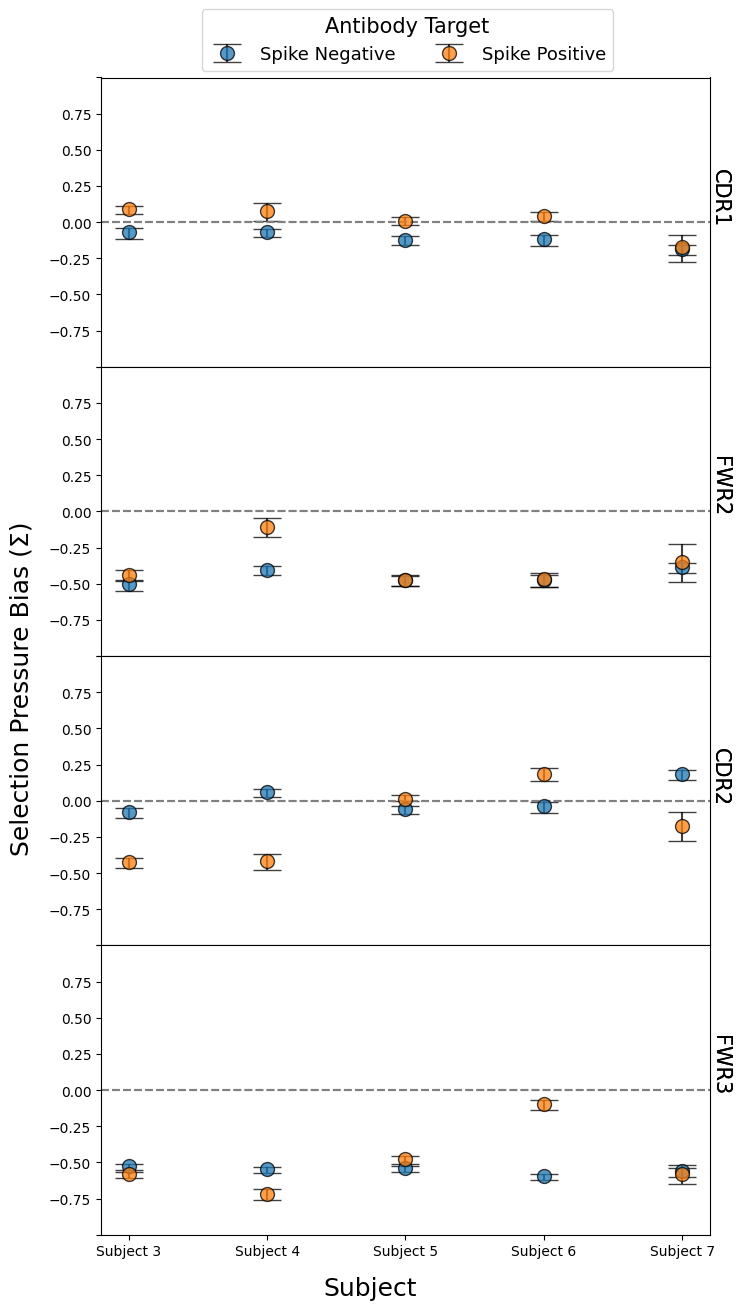

Plot saves as motif_tp4_[2025-11-27_20-15-00]_baseline_values


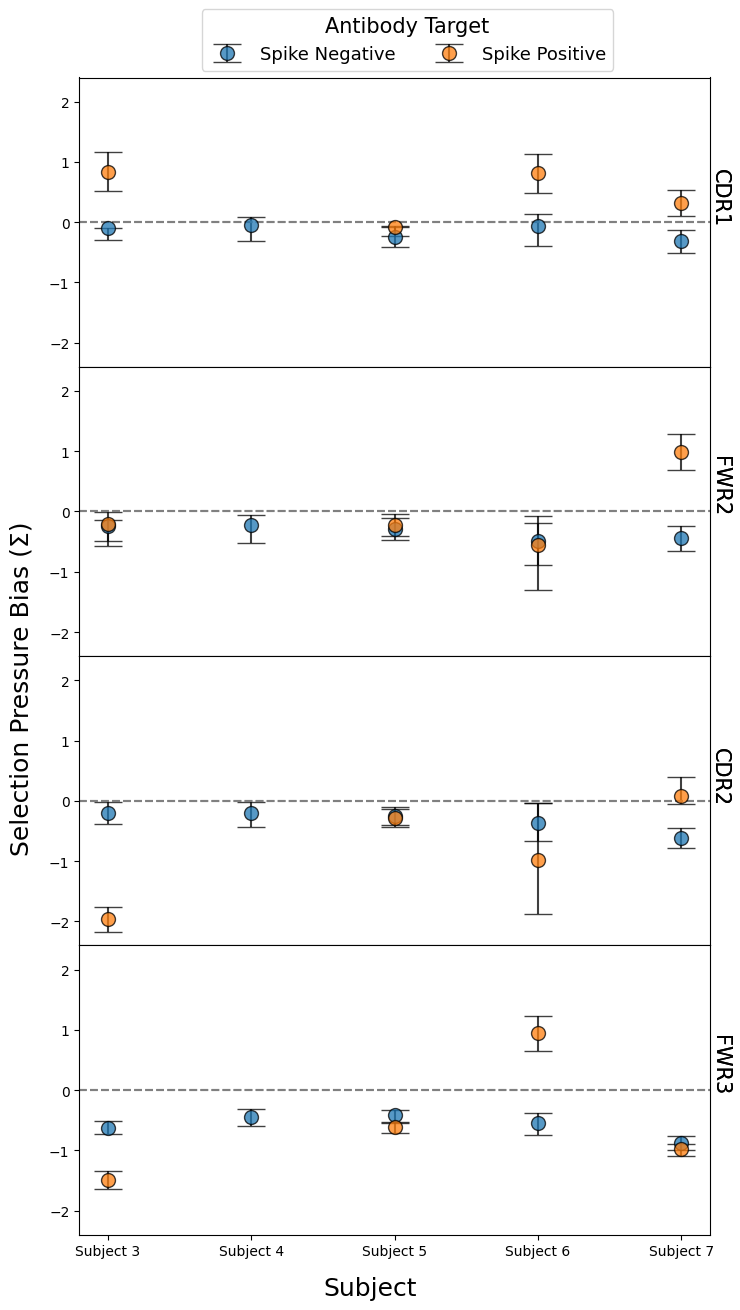

In [4]:
# Plotting figures based on the datasets:
for dt in datasets_input:
    plot_selection(dataset_path=dt,
                   metadata_split="Antibody Target")